In [1]:
import pypsa
import pandas as pd
import xarray as xr

n = pypsa.Network("pypsa-eur-test/results/networks/elec_s_37_ec_lcopt_Co2L0.7-24H.nc")

print(n)

INFO:pypsa.io:Imported network elec_s_37_ec_lcopt_Co2L0.7-24H.nc has buses, carriers, generators, global_constraints, lines, links, loads, shapes, storage_units, stores


PyPSA Network
Components:
 - Bus: 111
 - Carrier: 26
 - Generator: 326
 - GlobalConstraint: 1
 - Line: 52
 - Link: 198
 - Load: 37
 - Shape: 123
 - StorageUnit: 50
 - Store: 74
Snapshots: 366


(<matplotlib.collections.PatchCollection at 0x15adee010>,
 <matplotlib.collections.LineCollection at 0x15add5b90>)

/opt/anaconda3/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".



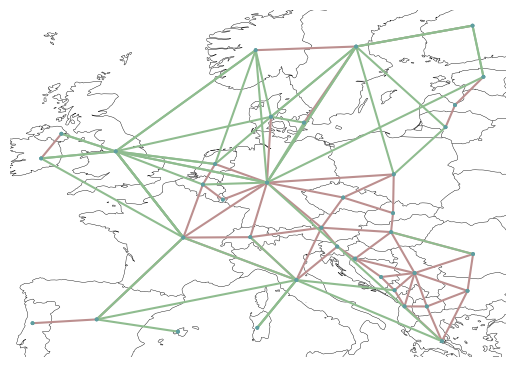

In [2]:
n.plot()

In [3]:
n.add("Carrier", "SBSP", co2_emissions=0.0036)

ac_buses = n.buses[n.buses['carrier'] == 'AC']

for bus in ac_buses.index:
    n.add("Generator", f"SBSP Generator at {bus}", 
          bus=bus,  
          carrier="SBSP",  
          p_nom_min=0.0,  # MW
          marginal_cost=0.0,  # EUR/MWh
          capital_cost=267869.95440170984,  # EUR/MW
          p_nom_extendable=True  
         )

sbsp_limits = xr.open_dataset("sbsp_rd1_profile_2020.nc")
effective_power = sbsp_limits["Effective Power (MW)"].to_dataframe()

effective_power.index = pd.to_datetime(effective_power.index)

daily_effective_power = effective_power.resample('24H').mean()

for gen_id in n.generators.index:
    if n.generators.loc[gen_id, 'carrier'] == 'SBSP':
        n.generators.loc[gen_id, 'p_nom'] = daily_effective_power['Effective Power (MW)'].max()  # 设置一个合理的 p_nom 值
        n.generators.loc[gen_id, 'p_nom_max'] = daily_effective_power['Effective Power (MW)'].max()  # 设置 p_nom_max
        
        for timestamp in daily_effective_power.index:
            n.generators_t.p_max_pu.loc[timestamp, gen_id] = daily_effective_power.loc[timestamp, 'Effective Power (MW)'] / n.generators.loc[gen_id, 'p_nom_max']

/var/folders/gy/z7x44kpn24d18spbg3w6_5fr0000gn/T/ipykernel_2407/302468231.py:20: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



In [4]:
committable_carriers = ["oil", "biomass", "nuclear", "ror", "lignite", "coal", "geothermal"]

for gen_id, generator in n.generators.iterrows():
    if generator['carrier'] in committable_carriers:
        n.generators.at[gen_id, 'committable'] = True

In [5]:
new_co2_emissions = {
    "solar-hsat": 0.0090566,
    "solar": 0.0090566,
    "onwind": 0.00801887,
    "offwind-ac": 0.00943396,
    "offwind-dc": 0.00943396,
    "offwind-float": 0.00943396
}

for carrier, co2_value in new_co2_emissions.items():
    if carrier in n.carriers.index:
        n.carriers.at[carrier, "co2_emissions"] = co2_value
    else:
        print(f"Carrier {carrier} not found in the network.")

print(n.carriers[["co2_emissions"]])

                    co2_emissions
Carrier                          
AC                       0.000000
DC                       0.000000
oil                      0.294000
OCGT                     0.240000
biomass                  0.000468
nuclear                  0.004743
geothermal               0.035283
CCGT                     0.240000
lignite                  0.406900
coal                     0.336100
hydro                    0.023774
offwind-float            0.009434
offwind-dc               0.009434
solar                    0.009057
solar-hsat               0.009057
onwind                   0.008019
offwind-ac               0.009434
ror                      0.023774
PHS                      0.008491
                         0.000000
battery                  0.000000
H2                       0.000000
battery charger          0.000000
battery discharger       0.000000
H2 fuel cell             0.000000
H2 electrolysis          0.000000
SBSP                     0.003600


In [6]:
pd.set_option('display.max_columns', None)
n.generators

,carrier,bus,p_nom_min,p_nom,p_nom_extendable,efficiency,marginal_cost,capital_cost,committable,ramp_limit_up,ramp_limit_start_up,ramp_limit_shut_down,p_min_pu,min_up_time,min_down_time,start_up_cost,p_nom_max,p_max_pu,weight,control,p_nom_opt,type,p_nom_mod,p_set,q_set,sign,marginal_cost_quadratic,build_year,lifetime,shut_down_cost,stand_by_cost,up_time_before,down_time_before,ramp_limit_down
Generator,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AL1 0 offwind-ac,offwind-ac,AL1 0,0.000000,0.000000,True,0.500,5.009241,241596.206534,False,NaN,1.0,1.0,0.0,0,0,0.0,2.804437e+03,1.0,453.150002,Slack,0.000151,,0.0,0.0,0.0,1.0,0.0,0,inf,0.0,0.0,1,0,NaN
AL1 0 offwind-float,offwind-float,AL1 0,0.000000,0.000000,True,0.500,5.010653,256506.087174,False,NaN,1.0,1.0,0.0,0,0,0.0,7.592113e+03,1.0,1613.984046,,0.000153,,0.0,0.0,0.0,1.0,0.0,0,inf,0.0,0.0,1,0,NaN
AL1 0 oil,oil,AL1 0,89.854543,89.854543,False,0.350,157.565014,40382.063710,True,NaN,1.0,1.0,0.0,0,0,0.0,inf,1.0,1.000000,,89.854543,,0.0,0.0,0.0,1.0,0.0,0,inf,0.0,0.0,1,0,NaN
AL1 0 onwind,onwind,AL1 0,0.000000,0.000000,True,0.425,2.123352,108625.310225,False,NaN,1.0,1.0,0.0,0,0,0.0,6.780099e+04,1.0,1823.843139,,0.000236,,0.0,0.0,0.0,1.0,0.0,0,inf,0.0,0.0,1,0,NaN
AL1 0 ror,ror,AL1 0,0.000000,48.200000,False,0.900,0.009686,308170.371903,True,NaN,1.0,1.0,0.0,0,0,0.0,inf,1.0,48.200000,,48.200000,,0.0,0.0,0.0,1.0,0.0,0,inf,0.0,0.0,1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SBSP Generator at RO1 0,SBSP,RO1 0,0.000000,2733.640308,True,1.000,0.000000,267869.954402,False,NaN,1.0,1.0,0.0,0,0,0.0,2.733640e+03,1.0,1.000000,PQ,0.000000,,0.0,0.0,0.0,1.0,0.0,0,inf,0.0,0.0,1,0,NaN
SBSP Generator at RS1 0,SBSP,RS1 0,0.000000,2733.640308,True,1.000,0.000000,267869.954402,False,NaN,1.0,1.0,0.0,0,0,0.0,2.733640e+03,1.0,1.000000,PQ,0.000000,,0.0,0.0,0.0,1.0,0.0,0,inf,0.0,0.0,1,0,NaN
SBSP Generator at SE2 0,SBSP,SE2 0,0.000000,2733.640308,True,1.000,0.000000,267869.954402,False,NaN,1.0,1.0,0.0,0,0,0.0,2.733640e+03,1.0,1.000000,PQ,0.000000,,0.0,0.0,0.0,1.0,0.0,0,inf,0.0,0.0,1,0,NaN


In [7]:
n.carriers

,co2_emissions,color,nice_name,max_growth,max_relative_growth
Carrier,,,,,
AC,0.000000,#70af1d,AC,inf,0.0
DC,0.000000,#8a1caf,DC,inf,0.0
oil,0.294000,#c9c9c9,oil,inf,0.0
OCGT,0.240000,#e0986c,Open-Cycle Gas,inf,0.0
biomass,0.000468,#baa741,biomass,inf,0.0
nuclear,0.004743,#ff8c00,nuclear,inf,0.0
geothermal,0.035283,#ba91b1,geothermal,inf,0.0
CCGT,0.240000,#a85522,Combined-Cycle Gas,inf,0.0
lignite,0.406900,#826837,lignite,inf,0.0


In [ ]:
snapshots_to_optimize = n.snapshots[:366]

n.optimize(snapshots=snapshots_to_optimize, solver_name='gurobi')

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████████████| 3/3 [00:00<00:00, 39.57it/s]
INFO:linopy.io: Writing time: 5.47s


Read LP format model from file /private/var/folders/gy/z7x44kpn24d18spbg3w6_5fr0000gn/T/linopy-problem-39_f5ujp.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/gy/z7x44kpn24d18spbg3w6_5fr0000gn/T/linopy-problem-39_f5ujp.lp


Reading time = 1.95 seconds


INFO:gurobipy:Reading time = 1.95 seconds


obj: 893979 rows, 492796 columns, 2377106 nonzeros


INFO:gurobipy:obj: 893979 rows, 492796 columns, 2377106 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M1


INFO:gurobipy:CPU model: Apple M1


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 893979 rows, 492796 columns and 2377106 nonzeros


INFO:gurobipy:Optimize a model with 893979 rows, 492796 columns and 2377106 nonzeros


Model fingerprint: 0xef04488c


INFO:gurobipy:Model fingerprint: 0xef04488c


Variable types: 343468 continuous, 149328 integer (149328 binary)


INFO:gurobipy:Variable types: 343468 continuous, 149328 integer (149328 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-02, 4e+04]


INFO:gurobipy:  Matrix range     [1e-02, 4e+04]


  Objective range  [2e-01, 3e+05]


INFO:gurobipy:  Objective range  [2e-01, 3e+05]


  Bounds range     [1e-01, 7e+10]


INFO:gurobipy:  Bounds range     [1e-01, 7e+10]


  RHS range        [1e-01, 1e+09]


INFO:gurobipy:  RHS range        [1e-01, 1e+09]


INFO:gurobipy:Warning: Model contains large rhs


INFO:gurobipy:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 407202 rows and 104373 columns


INFO:gurobipy:Presolve removed 407202 rows and 104373 columns


Presolve time: 4.94s


INFO:gurobipy:Presolve time: 4.94s


Presolved: 486777 rows, 388423 columns, 1853864 nonzeros


INFO:gurobipy:Presolved: 486777 rows, 388423 columns, 1853864 nonzeros


Variable types: 303444 continuous, 84979 integer (84979 binary)


INFO:gurobipy:Variable types: 303444 continuous, 84979 integer (84979 binary)


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Root barrier log...


INFO:gurobipy:Root barrier log...


INFO:gurobipy:


Ordering time: 8.44s


INFO:gurobipy:Ordering time: 8.44s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 510


INFO:gurobipy: Dense cols : 510


 AA' NZ     : 2.942e+06


INFO:gurobipy: AA' NZ     : 2.942e+06


 Factor NZ  : 3.030e+07 (roughly 600 MB of memory)


INFO:gurobipy: Factor NZ  : 3.030e+07 (roughly 600 MB of memory)


 Factor Ops : 3.958e+10 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 3.958e+10 (less than 1 second per iteration)


 Threads    : 5


INFO:gurobipy: Threads    : 5


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.26021401e+14 -4.18708210e+15  2.74e+10 1.15e+04  9.40e+11    20s


INFO:gurobipy:   0   4.26021401e+14 -4.18708210e+15  2.74e+10 1.15e+04  9.40e+11    20s


   1   4.56867517e+14 -3.42567136e+15  2.13e+10 4.93e+05  6.52e+11    21s


INFO:gurobipy:   1   4.56867517e+14 -3.42567136e+15  2.13e+10 4.93e+05  6.52e+11    21s


   2   3.06013330e+14 -2.64934281e+15  1.35e+10 8.77e+03  3.76e+11    21s


INFO:gurobipy:   2   3.06013330e+14 -2.64934281e+15  1.35e+10 8.77e+03  3.76e+11    21s


   3   3.24654894e+13 -2.05077051e+15  5.26e+08 3.75e+04  1.64e+10    22s


INFO:gurobipy:   3   3.24654894e+13 -2.05077051e+15  5.26e+08 3.75e+04  1.64e+10    22s


   4   1.54704024e+13 -1.11533728e+15  9.99e+07 1.78e+04  3.56e+09    23s


INFO:gurobipy:   4   1.54704024e+13 -1.11533728e+15  9.99e+07 1.78e+04  3.56e+09    23s


   5   1.05545814e+13 -6.22684112e+14  2.29e+07 9.33e+03  1.10e+09    25s


INFO:gurobipy:   5   1.05545814e+13 -6.22684112e+14  2.29e+07 9.33e+03  1.10e+09    25s


   6   5.57171282e+12 -1.16287224e+14  1.76e+06 1.14e+04  1.41e+08    26s


INFO:gurobipy:   6   5.57171282e+12 -1.16287224e+14  1.76e+06 1.14e+04  1.41e+08    26s


   7   3.05804374e+12 -3.25330789e+13  8.03e+04 2.20e+03  3.31e+07    28s


INFO:gurobipy:   7   3.05804374e+12 -3.25330789e+13  8.03e+04 2.20e+03  3.31e+07    28s


   8   1.83903094e+12 -9.60137531e+12  6.32e+03 5.73e+02  1.04e+07    29s


INFO:gurobipy:   8   1.83903094e+12 -9.60137531e+12  6.32e+03 5.73e+02  1.04e+07    29s


   9   1.20715952e+12 -4.27581258e+12  1.80e+03 2.38e+02  5.01e+06    30s


INFO:gurobipy:   9   1.20715952e+12 -4.27581258e+12  1.80e+03 2.38e+02  5.01e+06    30s


  10   6.67600857e+11 -2.04394633e+12  9.65e+00 1.00e+02  2.47e+06    32s


INFO:gurobipy:  10   6.67600857e+11 -2.04394633e+12  9.65e+00 1.00e+02  2.47e+06    32s


  11   4.25374654e+11 -1.57639925e+12  5.54e+00 7.54e+01  1.82e+06    33s


INFO:gurobipy:  11   4.25374654e+11 -1.57639925e+12  5.54e+00 7.54e+01  1.82e+06    33s


  12   3.11177844e+11 -7.84854596e+11  3.72e+00 3.59e+01  9.92e+05    34s


INFO:gurobipy:  12   3.11177844e+11 -7.84854596e+11  3.72e+00 3.59e+01  9.92e+05    34s


  13   2.64266109e+11 -5.02259502e+11  3.02e+00 2.32e+01  6.93e+05    35s


INFO:gurobipy:  13   2.64266109e+11 -5.02259502e+11  3.02e+00 2.32e+01  6.93e+05    35s


  14   2.30499745e+11 -3.60086476e+11  2.55e+00 1.67e+01  5.33e+05    36s


INFO:gurobipy:  14   2.30499745e+11 -3.60086476e+11  2.55e+00 1.67e+01  5.33e+05    36s


  15   1.88754523e+11 -2.99031927e+11  2.00e+00 1.39e+01  4.40e+05    37s


INFO:gurobipy:  15   1.88754523e+11 -2.99031927e+11  2.00e+00 1.39e+01  4.40e+05    37s


  16   1.49863335e+11 -2.42185605e+11  1.52e+00 1.14e+01  3.53e+05    38s


INFO:gurobipy:  16   1.49863335e+11 -2.42185605e+11  1.52e+00 1.14e+01  3.53e+05    38s


  17   1.12775221e+11 -1.23154898e+11  1.08e+00 6.13e+00  2.12e+05    39s


INFO:gurobipy:  17   1.12775221e+11 -1.23154898e+11  1.08e+00 6.13e+00  2.12e+05    39s


  18   7.88125614e+10 -3.34854670e+10  6.68e-01 2.01e+00  1.01e+05    41s


INFO:gurobipy:  18   7.88125614e+10 -3.34854670e+10  6.68e-01 2.01e+00  1.01e+05    41s


  19   5.13080083e+10 -7.87706231e+08  3.63e-01 6.11e-01  4.69e+04    42s


INFO:gurobipy:  19   5.13080083e+10 -7.87706231e+08  3.63e-01 6.11e-01  4.69e+04    42s


  20   3.69132430e+10  1.18112178e+10  2.13e-01 1.54e-01  2.26e+04    44s


INFO:gurobipy:  20   3.69132430e+10  1.18112178e+10  2.13e-01 1.54e-01  2.26e+04    44s


  21   3.18329681e+10  1.45426175e+10  1.57e-01 8.26e-02  1.56e+04    46s


INFO:gurobipy:  21   3.18329681e+10  1.45426175e+10  1.57e-01 8.26e-02  1.56e+04    46s


  22   2.81009281e+10  1.63592900e+10  1.15e-01 3.93e-02  1.06e+04    47s


INFO:gurobipy:  22   2.81009281e+10  1.63592900e+10  1.15e-01 3.93e-02  1.06e+04    47s


  23   2.68204869e+10  1.69360562e+10  9.96e-02 2.81e-02  8.91e+03    48s


INFO:gurobipy:  23   2.68204869e+10  1.69360562e+10  9.96e-02 2.81e-02  8.91e+03    48s


  24   2.45404141e+10  1.73982818e+10  7.46e-02 2.00e-02  6.44e+03    49s


INFO:gurobipy:  24   2.45404141e+10  1.73982818e+10  7.46e-02 2.00e-02  6.44e+03    49s


  25   2.33675565e+10  1.76286673e+10  5.94e-02 1.59e-02  5.17e+03    50s


INFO:gurobipy:  25   2.33675565e+10  1.76286673e+10  5.94e-02 1.59e-02  5.17e+03    50s


  26   2.23509699e+10  1.79238338e+10  4.77e-02 1.12e-02  3.99e+03    51s


INFO:gurobipy:  26   2.23509699e+10  1.79238338e+10  4.77e-02 1.12e-02  3.99e+03    51s


  27   2.10482751e+10  1.81476570e+10  3.14e-02 7.91e-03  2.62e+03    53s


INFO:gurobipy:  27   2.10482751e+10  1.81476570e+10  3.14e-02 7.91e-03  2.62e+03    53s


  28   2.05213949e+10  1.83086466e+10  2.48e-02 5.71e-03  2.00e+03    54s


INFO:gurobipy:  28   2.05213949e+10  1.83086466e+10  2.48e-02 5.71e-03  2.00e+03    54s


  29   2.00036701e+10  1.84764223e+10  1.77e-02 3.57e-03  1.38e+03    56s


INFO:gurobipy:  29   2.00036701e+10  1.84764223e+10  1.77e-02 3.57e-03  1.38e+03    56s


  30   1.96213958e+10  1.85565652e+10  1.25e-02 2.59e-03  9.61e+02    57s


INFO:gurobipy:  30   1.96213958e+10  1.85565652e+10  1.25e-02 2.59e-03  9.61e+02    57s


  31   1.93937373e+10  1.86232600e+10  9.29e-03 1.75e-03  6.96e+02    58s


INFO:gurobipy:  31   1.93937373e+10  1.86232600e+10  9.29e-03 1.75e-03  6.96e+02    58s


  32   1.92045335e+10  1.86715170e+10  6.59e-03 1.15e-03  4.81e+02    59s


INFO:gurobipy:  32   1.92045335e+10  1.86715170e+10  6.59e-03 1.15e-03  4.81e+02    59s


  33   1.90885705e+10  1.87028864e+10  4.84e-03 7.62e-04  3.48e+02    61s


INFO:gurobipy:  33   1.90885705e+10  1.87028864e+10  4.84e-03 7.62e-04  3.48e+02    61s


  34   1.90113997e+10  1.87245589e+10  3.67e-03 5.12e-04  2.59e+02    62s


INFO:gurobipy:  34   1.90113997e+10  1.87245589e+10  3.67e-03 5.12e-04  2.59e+02    62s


  35   1.89439470e+10  1.87423943e+10  2.68e-03 3.11e-04  1.82e+02    63s


INFO:gurobipy:  35   1.89439470e+10  1.87423943e+10  2.68e-03 3.11e-04  1.82e+02    63s


  36   1.89072017e+10  1.87480055e+10  2.16e-03 2.49e-04  1.44e+02    65s


INFO:gurobipy:  36   1.89072017e+10  1.87480055e+10  2.16e-03 2.49e-04  1.44e+02    65s


  37   1.88608407e+10  1.87577226e+10  1.38e-03 1.40e-04  9.32e+01    66s


INFO:gurobipy:  37   1.88608407e+10  1.87577226e+10  1.38e-03 1.40e-04  9.32e+01    66s


  38   1.88408452e+10  1.87643283e+10  1.08e-03 7.61e-05  6.92e+01    67s


INFO:gurobipy:  38   1.88408452e+10  1.87643283e+10  1.08e-03 7.61e-05  6.92e+01    67s


  39   1.88152140e+10  1.87676908e+10  6.99e-04 4.60e-05  4.30e+01    69s


INFO:gurobipy:  39   1.88152140e+10  1.87676908e+10  6.99e-04 4.60e-05  4.30e+01    69s


  40   1.88052642e+10  1.87690054e+10  5.39e-04 3.43e-05  3.28e+01    70s


INFO:gurobipy:  40   1.88052642e+10  1.87690054e+10  5.39e-04 3.43e-05  3.28e+01    70s


  41   1.87954270e+10  1.87706403e+10  3.85e-04 2.18e-05  2.25e+01    71s


INFO:gurobipy:  41   1.87954270e+10  1.87706403e+10  3.85e-04 2.18e-05  2.25e+01    71s


  42   1.87892914e+10  1.87715014e+10  2.77e-04 1.41e-05  1.61e+01    73s


INFO:gurobipy:  42   1.87892914e+10  1.87715014e+10  2.77e-04 1.41e-05  1.61e+01    73s


  43   1.87841890e+10  1.87721089e+10  2.29e-04 9.40e-06  1.09e+01    74s


INFO:gurobipy:  43   1.87841890e+10  1.87721089e+10  2.29e-04 9.40e-06  1.09e+01    74s


  44   1.87825310e+10  1.87723797e+10  1.94e-04 7.25e-06  9.20e+00    75s


INFO:gurobipy:  44   1.87825310e+10  1.87723797e+10  1.94e-04 7.25e-06  9.20e+00    75s


  45   1.87801295e+10  1.87727264e+10  1.67e-04 4.51e-06  6.71e+00    76s


INFO:gurobipy:  45   1.87801295e+10  1.87727264e+10  1.67e-04 4.51e-06  6.71e+00    76s


  46   1.87769100e+10  1.87729576e+10  1.31e-04 2.85e-06  3.59e+00    78s


INFO:gurobipy:  46   1.87769100e+10  1.87729576e+10  1.31e-04 2.85e-06  3.59e+00    78s


  47   1.87751747e+10  1.87730985e+10  6.53e-05 1.91e-06  1.88e+00    79s


INFO:gurobipy:  47   1.87751747e+10  1.87730985e+10  6.53e-05 1.91e-06  1.88e+00    79s


  48   1.87748495e+10  1.87731915e+10  6.76e-05 1.35e-06  1.50e+00    80s


INFO:gurobipy:  48   1.87748495e+10  1.87731915e+10  6.76e-05 1.35e-06  1.50e+00    80s


  49   1.87743015e+10  1.87733039e+10  4.57e-05 7.08e-07  9.05e-01    82s


INFO:gurobipy:  49   1.87743015e+10  1.87733039e+10  4.57e-05 7.08e-07  9.05e-01    82s


  50   1.87740242e+10  1.87733578e+10  3.55e-05 4.16e-07  6.05e-01    83s


INFO:gurobipy:  50   1.87740242e+10  1.87733578e+10  3.55e-05 4.16e-07  6.05e-01    83s


  51   1.87737933e+10  1.87733912e+10  2.54e-05 2.29e-07  3.65e-01    85s


INFO:gurobipy:  51   1.87737933e+10  1.87733912e+10  2.54e-05 2.29e-07  3.65e-01    85s


  52   1.87736323e+10  1.87734133e+10  1.61e-05 1.28e-07  1.99e-01    86s


INFO:gurobipy:  52   1.87736323e+10  1.87734133e+10  1.61e-05 1.28e-07  1.99e-01    86s


  53   1.87735279e+10  1.87734205e+10  7.28e-06 9.48e-08  9.74e-02    88s


INFO:gurobipy:  53   1.87735279e+10  1.87734205e+10  7.28e-06 9.48e-08  9.74e-02    88s


  54   1.87734629e+10  1.87734382e+10  3.51e-06 6.15e-08  2.25e-02    90s


INFO:gurobipy:  54   1.87734629e+10  1.87734382e+10  3.51e-06 6.15e-08  2.25e-02    90s


  55   1.87734543e+10  1.87734427e+10  1.63e-06 2.98e-08  1.05e-02    92s


INFO:gurobipy:  55   1.87734543e+10  1.87734427e+10  1.63e-06 2.98e-08  1.05e-02    92s


  56   1.87734502e+10  1.87734443e+10  7.69e-07 2.98e-08  5.38e-03    93s


INFO:gurobipy:  56   1.87734502e+10  1.87734443e+10  7.69e-07 2.98e-08  5.38e-03    93s


  57   1.87734481e+10  1.87734456e+10  2.72e-06 3.91e-08  2.27e-03    95s


INFO:gurobipy:  57   1.87734481e+10  1.87734456e+10  2.72e-06 3.91e-08  2.27e-03    95s


  58   1.87734463e+10  1.87734460e+10  9.78e-06 5.96e-08  2.79e-04    96s


INFO:gurobipy:  58   1.87734463e+10  1.87734460e+10  9.78e-06 5.96e-08  2.79e-04    96s


  59   1.87734461e+10  1.87734461e+10  8.13e-07 8.94e-08  2.64e-05    98s


INFO:gurobipy:  59   1.87734461e+10  1.87734461e+10  8.13e-07 8.94e-08  2.64e-05    98s


  60   1.87734461e+10  1.87734461e+10  1.10e-07 1.93e-08  1.25e-06    99s


INFO:gurobipy:  60   1.87734461e+10  1.87734461e+10  1.10e-07 1.93e-08  1.25e-06    99s


  61   1.87734461e+10  1.87734461e+10  1.99e-08 2.98e-08  2.95e-08   101s


INFO:gurobipy:  61   1.87734461e+10  1.87734461e+10  1.99e-08 2.98e-08  2.95e-08   101s


  62   1.87734461e+10  1.87734461e+10  6.71e-07 4.19e-08  1.75e-09   102s


INFO:gurobipy:  62   1.87734461e+10  1.87734461e+10  6.71e-07 4.19e-08  1.75e-09   102s


INFO:gurobipy:


Barrier solved model in 62 iterations and 102.48 seconds (90.07 work units)


INFO:gurobipy:Barrier solved model in 62 iterations and 102.48 seconds (90.07 work units)


Optimal objective 1.87734461e+10


INFO:gurobipy:Optimal objective 1.87734461e+10


INFO:gurobipy:


INFO:gurobipy:


Root crossover log...


INFO:gurobipy:Root crossover log...


INFO:gurobipy:


  265496 DPushes remaining with DInf 0.0000000e+00               103s


INFO:gurobipy:  265496 DPushes remaining with DInf 0.0000000e+00               103s


   84343 DPushes remaining with DInf 0.0000000e+00               109s


INFO:gurobipy:   84343 DPushes remaining with DInf 0.0000000e+00               109s


   39356 DPushes remaining with DInf 0.0000000e+00               110s


INFO:gurobipy:   39356 DPushes remaining with DInf 0.0000000e+00               110s


    1231 DPushes remaining with DInf 0.0000000e+00               117s


INFO:gurobipy:    1231 DPushes remaining with DInf 0.0000000e+00               117s


     102 DPushes remaining with DInf 0.0000000e+00               120s


INFO:gurobipy:     102 DPushes remaining with DInf 0.0000000e+00               120s


       0 DPushes remaining with DInf 0.0000000e+00               121s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00               121s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


    2315 PPushes remaining with PInf 1.0110127e-01               121s


INFO:gurobipy:    2315 PPushes remaining with PInf 1.0110127e-01               121s


       0 PPushes remaining with PInf 0.0000000e+00               124s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00               124s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 7.0415493e+06    124s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 7.0415493e+06    124s


INFO:gurobipy:


INFO:gurobipy:


Root simplex log...


INFO:gurobipy:Root simplex log...


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  187593    1.8773446e+10   0.000000e+00   7.041549e+06    124s


INFO:gurobipy:  187593    1.8773446e+10   0.000000e+00   7.041549e+06    124s


  187711    1.8773446e+10   0.000000e+00   0.000000e+00    125s


INFO:gurobipy:  187711    1.8773446e+10   0.000000e+00   0.000000e+00    125s


Waiting for other threads to finish...         185s


INFO:gurobipy:Waiting for other threads to finish...         185s


Concurrent spin time: 74.92s (can be avoided by choosing Method=3)


INFO:gurobipy:Concurrent spin time: 74.92s (can be avoided by choosing Method=3)


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


INFO:gurobipy:


Root relaxation: objective 1.877345e+10, 187711 iterations, 192.84 seconds (92.69 work units)


INFO:gurobipy:Root relaxation: objective 1.877345e+10, 187711 iterations, 192.84 seconds (92.69 work units)


Total elapsed time = 209.02s (DegenMoves)


INFO:gurobipy:Total elapsed time = 209.02s (DegenMoves)


Total elapsed time = 210.66s (DegenMoves)


INFO:gurobipy:Total elapsed time = 210.66s (DegenMoves)


INFO:gurobipy:


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


     0     0 1.8773e+10    0 3535          - 1.8773e+10      -     -  212s


INFO:gurobipy:     0     0 1.8773e+10    0 3535          - 1.8773e+10      -     -  212s


H    0     0                    4.309328e+12 1.8773e+10   100%     -  354s


INFO:gurobipy:H    0     0                    4.309328e+12 1.8773e+10   100%     -  354s


     0     0 1.8797e+10    0 3140 4.3093e+12 1.8797e+10   100%     -  612s


INFO:gurobipy:     0     0 1.8797e+10    0 3140 4.3093e+12 1.8797e+10   100%     -  612s


     0     0 1.8798e+10    0 3163 4.3093e+12 1.8798e+10   100%     - 1194s


INFO:gurobipy:     0     0 1.8798e+10    0 3163 4.3093e+12 1.8798e+10   100%     - 1194s


     0     0 1.8799e+10    0 3150 4.3093e+12 1.8799e+10   100%     - 1201s


INFO:gurobipy:     0     0 1.8799e+10    0 3150 4.3093e+12 1.8799e+10   100%     - 1201s


     0     0 1.8799e+10    0 3148 4.3093e+12 1.8799e+10   100%     - 1202s


INFO:gurobipy:     0     0 1.8799e+10    0 3148 4.3093e+12 1.8799e+10   100%     - 1202s


     0     0 1.8806e+10    0 2889 4.3093e+12 1.8806e+10   100%     - 1302s


INFO:gurobipy:     0     0 1.8806e+10    0 2889 4.3093e+12 1.8806e+10   100%     - 1302s


     0     0 1.8806e+10    0 2874 4.3093e+12 1.8806e+10   100%     - 1508s


INFO:gurobipy:     0     0 1.8806e+10    0 2874 4.3093e+12 1.8806e+10   100%     - 1508s


     0     0 1.8808e+10    0 2712 4.3093e+12 1.8808e+10   100%     - 1626s


INFO:gurobipy:     0     0 1.8808e+10    0 2712 4.3093e+12 1.8808e+10   100%     - 1626s


     0     0 1.8808e+10    0 2734 4.3093e+12 1.8808e+10   100%     - 1640s


INFO:gurobipy:     0     0 1.8808e+10    0 2734 4.3093e+12 1.8808e+10   100%     - 1640s


     0     0 1.8808e+10    0 2684 4.3093e+12 1.8808e+10   100%     - 1646s


INFO:gurobipy:     0     0 1.8808e+10    0 2684 4.3093e+12 1.8808e+10   100%     - 1646s


     0     0 1.8809e+10    0 2725 4.3093e+12 1.8809e+10   100%     - 1731s


INFO:gurobipy:     0     0 1.8809e+10    0 2725 4.3093e+12 1.8809e+10   100%     - 1731s


     0     0 1.8809e+10    0 2732 4.3093e+12 1.8809e+10   100%     - 1733s


INFO:gurobipy:     0     0 1.8809e+10    0 2732 4.3093e+12 1.8809e+10   100%     - 1733s


     0     0 1.8809e+10    0 2656 4.3093e+12 1.8809e+10   100%     - 1754s


INFO:gurobipy:     0     0 1.8809e+10    0 2656 4.3093e+12 1.8809e+10   100%     - 1754s


     0     0 1.8809e+10    0 2658 4.3093e+12 1.8809e+10   100%     - 1756s


INFO:gurobipy:     0     0 1.8809e+10    0 2658 4.3093e+12 1.8809e+10   100%     - 1756s


     0     0 1.8809e+10    0 2594 4.3093e+12 1.8809e+10   100%     - 1760s


INFO:gurobipy:     0     0 1.8809e+10    0 2594 4.3093e+12 1.8809e+10   100%     - 1760s


     0     0 1.8809e+10    0 2594 4.3093e+12 1.8809e+10   100%     - 1767s


INFO:gurobipy:     0     0 1.8809e+10    0 2594 4.3093e+12 1.8809e+10   100%     - 1767s


     0     2 1.8809e+10    0 2594 4.3093e+12 1.8809e+10   100%     - 3105s


INFO:gurobipy:     0     2 1.8809e+10    0 2594 4.3093e+12 1.8809e+10   100%     - 3105s


     1     4 1.8852e+10    1 2548 4.3093e+12 1.8809e+10   100% 26586 3433s


INFO:gurobipy:     1     4 1.8852e+10    1 2548 4.3093e+12 1.8809e+10   100% 26586 3433s


     3     8 1.8932e+10    2 2871 4.3093e+12 1.8844e+10   100% 26969 4373s


INFO:gurobipy:     3     8 1.8932e+10    2 2871 4.3093e+12 1.8844e+10   100% 26969 4373s


     7    16 1.8976e+10    3 2990 4.3093e+12 1.8845e+10   100% 26903 5270s


INFO:gurobipy:     7    16 1.8976e+10    3 2990 4.3093e+12 1.8845e+10   100% 26903 5270s


In [9]:
import pandas as pd
generation_data = n.generators_t.p

carrier_generation = pd.Series(0.0, index=n.generators.carrier.unique())

for gen_id, generator in n.generators.iterrows():
    carrier = generator['carrier']
    carrier_generation[carrier] += generation_data[gen_id].sum()

print(carrier_generation)

offwind-ac       1.331686e+06
offwind-float    9.289619e+05
oil              0.000000e+00
onwind           1.793368e+07
ror              7.002640e+06
solar            7.867716e+06
solar-hsat       1.136536e+06
CCGT             5.635840e+05
coal             1.518781e+07
lignite          1.457223e+07
biomass          6.080552e+06
nuclear          3.335743e+07
offwind-dc       2.739671e+06
OCGT             0.000000e+00
geothermal       3.577000e+04
SBSP             1.709281e+07
dtype: float64


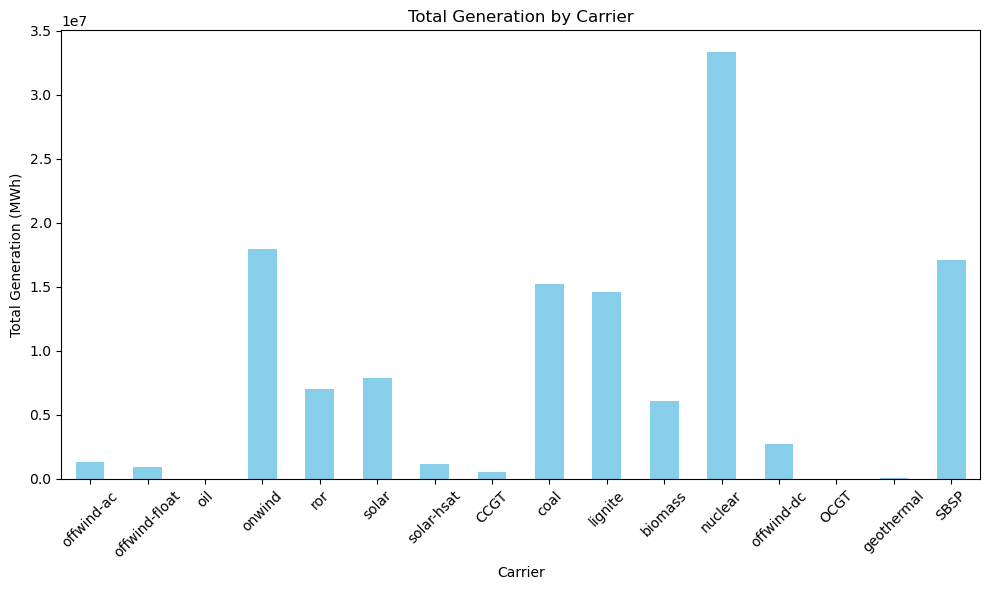

In [10]:
import matplotlib.pyplot as plt
carrier_generation.plot(kind='bar', color='skyblue', figsize=(10, 6))
plt.title('Total Generation by Carrier')
plt.xlabel('Carrier')
plt.ylabel('Total Generation (MWh)')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

In [11]:
SBSP_generators = n.generators[n.generators['carrier'] == 'SBSP']

SBSP_generation = n.generators_t.p[SBSP_generators.index]

active_SBSP_generators = SBSP_generation.loc[:, (SBSP_generation != 0).any(axis=0)]

active_SBSP_buses = SBSP_generators.loc[active_SBSP_generators.columns, 'bus'].unique()

print("Buses with active SBSP generators:")
print(active_SBSP_buses)

Buses with active SBSP generators:
['AL1 0' 'AT1 0' 'BA1 0' 'BE1 0' 'BG1 0' 'CZ1 0' 'DE1 0' 'EE6 0' 'ES1 0'
 'FR1 0' 'GB0 0' 'GB5 0' 'HR1 0' 'HU1 0' 'IE5 0' 'IT1 0' 'IT3 0' 'LT6 0'
 'LV6 0' 'ME1 0' 'NL1 0' 'NO2 0' 'PL1 0' 'PT1 0' 'SI1 0' 'SK1 0']


In [12]:
n.generators[["p_nom_opt"]]

,p_nom_opt
Generator,
AL1 0 offwind-ac,0.000000
AL1 0 offwind-float,0.000000
AL1 0 oil,89.854543
AL1 0 onwind,0.000000
AL1 0 ror,48.200000
...,...
SBSP Generator at RO1 0,0.000000
SBSP Generator at RS1 0,0.000000
SBSP Generator at SE2 0,0.000000


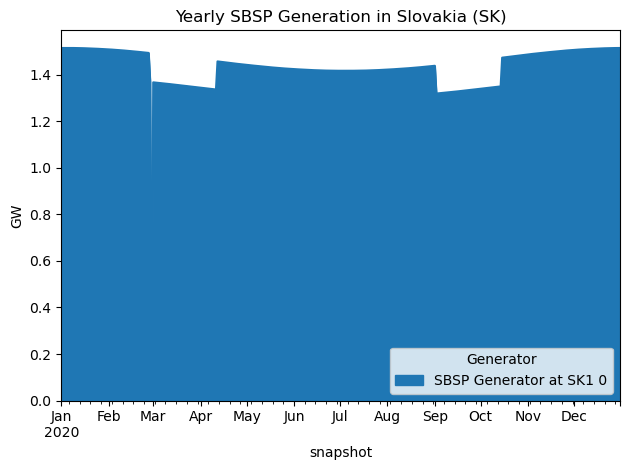

In [13]:
import matplotlib.pyplot as plt

sbsp_generators = n.generators[n.generators['carrier'] == 'SBSP']

sk_sbsp_generators = sbsp_generators[sbsp_generators['bus'].map(n.buses['country']) == 'SK']

sk_sbsp_generation = n.generators_t.p[sk_sbsp_generators.index]

sk_sbsp_generation_gw = sk_sbsp_generation.div(1e3)

sk_sbsp_generation_gw.plot.area(subplots=False, ylabel="GW")
plt.title('Yearly SBSP Generation in Slovakia (SK)')
plt.tight_layout()
plt.show()